<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# Tarea 3: Transformers y Stacked AutoEncoders

Fuentes:

- [BRISC](https://www.kaggle.com/datasets/briscdataset/brisc2025)


# Descargando datos

Usaremos la librería kagglehub para descargar los datos. Por defecto, los datos son descargados en la `cache` de `.root` necesitamos moverlos a nuestro directorio luego de descargar.

In [2]:
import kagglehub
path = kagglehub.dataset_download('briscdataset/brisc2025')

print('Descarga de datos completa.', path)

/home/deeplearning/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Descarga de datos completa. /home/deeplearning/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/5


In [3]:
!ls {path}

brisc2025


In [4]:
# quitar el anterior y usar copy para evitar descargar varias veces en un ambiente persistente (local)
!rm -r ./briscdataset
!cp -r {path}/brisc2025 ./briscdataset

Refresquen el directorio de Google Colab

# 🧠 BRISC 2025 Dataset Exploration

BRISC es un conjunto de datos de resonancias magnéticas de alta calidad, anotado por expertos, diseñado para la segmentación y clasificación de tumores cerebrales. Aborda limitaciones comunes en los conjuntos de datos existentes (p. ej., BraTS, Figshare), como el desequilibrio de clases, la focalización tumoral limitada y las inconsistencias en la anotación.

Esta sección provee métodos para entender los datos del dataset **BRISC 2025**. Está modificado para ser usado en `Google Colab` de un tutorial que funcionaba en `Kaggle`

1. Setup & Imports
2. Estructura del directorio  
3. Número de archivos y distribuciones
4. Representación gráfica de distribuciones
5. Numéro de clasificación por plano
6. Visualización de imágenes de muestra y máscaras
7. Histogramas de intensidad de píxeles
8. Análisis de metadatos de nombres de archivo
9. Ejemplo de superposición de máscaras
10. Cuadrícula aleatoria de muestras de clasificación


## ⚙️ 1. Setup & Imports

Librerías usadas por el tutorial. La mayoría conocidas:
- Archivo y manejo de directorios (`os`, `glob`)
- Datos (`pandas`, `numpy`)
- Procesamiento de imágenes (`PIL.Image`)
- Visualización (`matplotlib`)

Tomen en cuenta que usamos el directorio base luego de copiar en Google Colab.

In [5]:
# In[1] — Setup & Imports
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Render plots inline
%matplotlib inline


BASE_DIR = "briscdataset/"
print("✅ Final BASE_DIR =", BASE_DIR)



✅ Final BASE_DIR = briscdataset/


No cambien el código abajo, si copiaron bien los archivos debería verse como en la imagen

In [6]:
!ls {BASE_DIR}

classification_task  segmentation_task


## 📂 2. Estructura del directorio

Navegamos recursivamente en el `BASE_DIR` (profundidad=2)

In [7]:
# In[2] — Directory Tree
def walk_dir(base, max_depth=2):
    for root, dirs, _ in os.walk(base):
        depth = root.replace(base, "").count(os.sep)
        if depth <= max_depth:
            indent = "  " * depth
            print(f"{indent}{os.path.basename(root)}/")
            for d in dirs:
                print(f"{indent}  {d}/")

print("## BRISC2025 Folder Layout:")
walk_dir(BASE_DIR, max_depth=2)


## BRISC2025 Folder Layout:
/
  segmentation_task/
  classification_task/
segmentation_task/
  test/
  train/
  test/
    masks/
    images/
    masks/
    images/
  train/
    masks/
    images/
    masks/
    images/
classification_task/
  test/
  train/
  test/
    pituitary/
    no_tumor/
    meningioma/
    glioma/
    pituitary/
    no_tumor/
    meningioma/
    glioma/
  train/
    pituitary/
    no_tumor/
    meningioma/
    glioma/
    pituitary/
    no_tumor/
    meningioma/
    glioma/


## 📊 3. Distribución de archivos

Contando cada imagen `.jpg` en cada uno de los split/clases.


In [8]:
# File Count Logic (no need to change if BASE_DIR is fixed)
def count_patterns(patterns):
    return sum(len(glob.glob(p)) for p in patterns)

# Classification
splits = ["train", "test"]
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]
cls_records = []
for sp in splits:
    total = 0
    for cls in classes:
        pat = os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg")
        cnt = count_patterns([pat])
        cls_records.append({'Split': sp, 'Class': cls, 'Count': cnt})
        total += cnt
    cls_records.append({'Split': sp, 'Class': 'Total', 'Count': total})
df_cls = pd.DataFrame(cls_records)

# Segmentation
types_ = ["images", "masks"]
seg_records = []
for sp in splits:
    for tp in types_:
        pats = [
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.jpg"),
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.png")
        ]
        cnt = count_patterns(pats)
        seg_records.append({'Split': sp, 'Type': tp, 'Count': cnt})
df_seg = pd.DataFrame(seg_records)

# Display
print("### Classification Counts")
display(df_cls)
print("### Segmentation Counts")
display(df_seg)


### Classification Counts


,Split,Class,Count
0,train,glioma,1147
1,train,meningioma,1329
2,train,pituitary,1457
3,train,no_tumor,1067
4,train,Total,5000
5,test,glioma,254
6,test,meningioma,306
7,test,pituitary,300
8,test,no_tumor,140
9,test,Total,1000


### Segmentation Counts


,Split,Type,Count
0,train,images,3933
1,train,masks,3933
2,test,images,860
3,test,masks,860


## 📊 4. Gráficos por distribuciones

Visualización del conjunto de datos


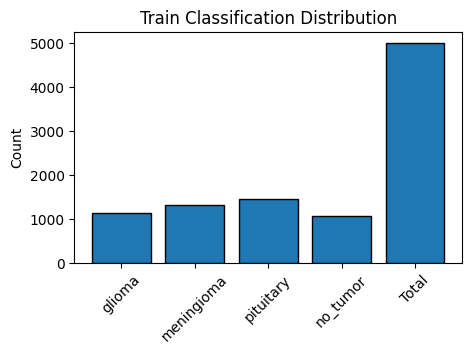

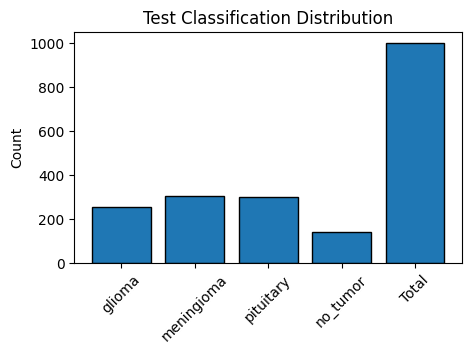

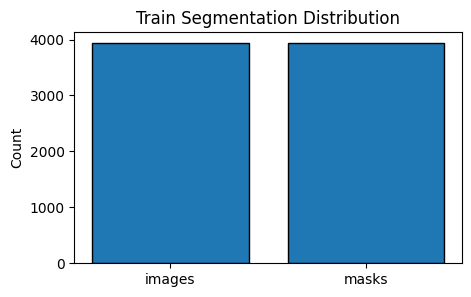

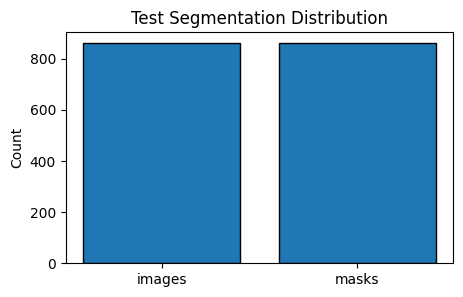

In [9]:
# In[4] — Distribution Plots
for sp in splits:
    sub = df_cls[df_cls.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Class, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Classification Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

for sp in splits:
    sub = df_seg[df_seg.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Type, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Segmentation Distribution")
    plt.ylabel("Count")
    plt.show()


## 📈 5. Clasificación por planos

Resumen anátomico dependiendo de los planos:

1. Ax: Axial
1. co: Coronal
1. sa: Sagittal

In [10]:
# In[5] — Per‑Plane Counts
planes = ["ax", "co", "sa"]
plane_records = []

for sp in splits:
    for cls in classes:
        for pl in planes:
            pat = os.path.join(
                BASE_DIR, "classification_task", sp, cls, f"*_{pl}_t1.jpg"
            )
            cnt = count_patterns([pat])
            plane_records.append({'Split': sp, 'Class': cls, 'Plane': pl, 'Count': cnt})

df_plane = pd.DataFrame(plane_records)
print("### Per‑Plane Counts Pivot")
display(df_plane.pivot_table(index='Plane', columns=['Split','Class'], values='Count'))


### Per‑Plane Counts Pivot


Split   test                                train                      \
Class glioma meningioma no_tumor pituitary glioma meningioma no_tumor   
Plane                                                                   
ax      85.0      137.0     52.0     124.0  394.0      423.0    352.0   
co      81.0       86.0     48.0      90.0  430.0      426.0    310.0   
sa      88.0       83.0     40.0      86.0  323.0      480.0    405.0   

Split            
Class pituitary  
Plane            
ax        426.0  
co        510.0  
sa        521.0

## 🖼️ 6. Imagen de ejemplo y máscaras

Ejemplo de una imagen de clasificación con su imagen de segmentación.

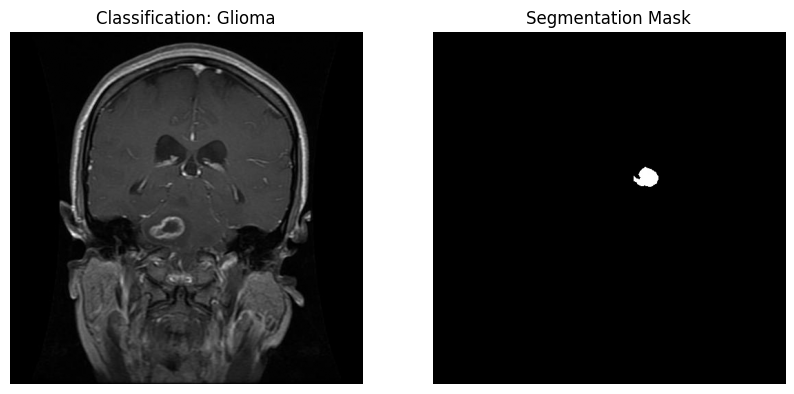

In [11]:
# In[6] — Sample Visualization
def first_file(folder, exts):
    for ext in exts:
        fl = glob.glob(os.path.join(folder, f"*.{ext}"))
        if fl: return fl[0]
    return None

img_path  = first_file(os.path.join(BASE_DIR, "classification_task/train/glioma"), ["jpg"])
mask_path = first_file(os.path.join(BASE_DIR, "segmentation_task/train/masks"), ["png","jpg"])

img  = Image.open(img_path)
mask = Image.open(mask_path)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img,  cmap="gray"); axes[0].set_title("Classification: Glioma"); axes[0].axis("off")
axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Segmentation Mask");    axes[1].axis("off")
plt.show()

## 📈 7. Histogramas de frecuencias por píxeles

Píxeles de las imágenes y las máscaras.

/tmp/ipykernel_167048/3109520795.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr_img  = np.array(img).ravel()
/tmp/ipykernel_167048/3109520795.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr_mask = np.array(mask).ravel()


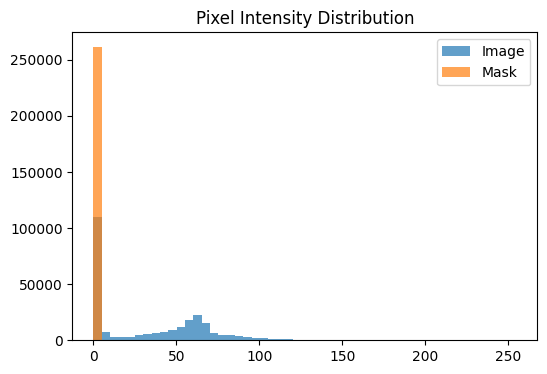

In [12]:
# In[7] — Histograms
arr_img  = np.array(img).ravel()
arr_mask = np.array(mask).ravel()

plt.figure(figsize=(6,4))
plt.hist(arr_img,  bins=50, alpha=0.7, label="Image")
plt.hist(arr_mask, bins=50, alpha=0.7, label="Mask")
plt.legend(); plt.title("Pixel Intensity Distribution"); plt.show()

## 📝 8. Parsing de metadata

Componentes del dataset transformados en una tabla. La columna Split dice a cuál corte irá cada imagen

In [13]:
# In[8] — Metadata Table
meta = []
for sp in splits:
    for cls in classes:
        # rafael: dependo de este objeto luego, asi que ahora el dataframe tiene TODAS las imagenes
        # antes solo tenia un subset
        files = glob.glob(os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg"))
        for f in files:
            parts = os.path.basename(f).split("_")
            meta.append({
                "Filename": os.path.basename(f),
                "Split": parts[1],
                "Index": parts[2],
                "Tumor": parts[3],
                "Plane": parts[4],
                "Sequence": parts[5].split(".")[0]
            })
df_meta = pd.DataFrame(meta)
print("### Sample Filename Metadata")
display(df_meta)

### Sample Filename Metadata


,Filename,Split,Index,Tumor,Plane,Sequence
0,brisc2025_train_00746_gl_co_t1.jpg,train,00746,gl,co,t1
1,brisc2025_train_00628_gl_co_t1.jpg,train,00628,gl,co,t1
2,brisc2025_train_00048_gl_ax_t1.jpg,train,00048,gl,ax,t1
3,brisc2025_train_00692_gl_co_t1.jpg,train,00692,gl,co,t1
4,brisc2025_train_00130_gl_ax_t1.jpg,train,00130,gl,ax,t1
...,...,...,...,...,...,...
5995,brisc2025_test_00649_no_co_t1.jpg,test,00649,no,co,t1
5996,brisc2025_test_00654_no_co_t1.jpg,test,00654,no,co,t1
5997,brisc2025_test_00633_no_co_t1.jpg,test,00633,no,co,t1
5998,brisc2025_test_00585_no_ax_t1.jpg,test,00585,no,ax,t1


## 🔍 9. ejemplo de Overlay de la máscara

Overlay de la máscara en rojo sobre la resonancia.

/tmp/ipykernel_167048/695026880.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img_rgb  = np.array(img.convert("RGB"))
/tmp/ipykernel_167048/695026880.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  mask_arr = np.array(mask)


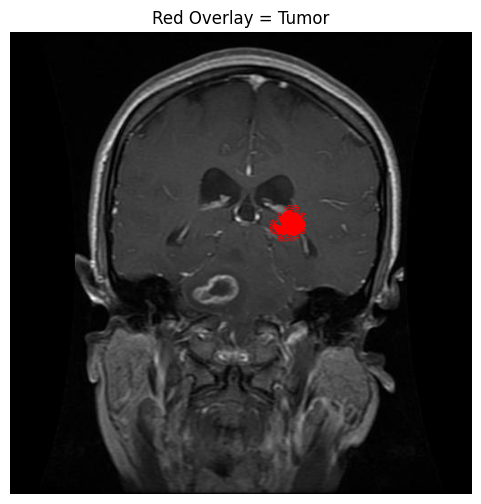

In [14]:
# In[9] — Overlay
img_rgb  = np.array(img.convert("RGB"))
mask_arr = np.array(mask)

overlay = img_rgb.copy()
overlay[mask_arr>0] = [255,0,0]

plt.figure(figsize=(6,6))
plt.imshow(overlay); plt.title("Red Overlay = Tumor"); plt.axis("off")
plt.show()

## 🔲 10. Grid aleatorio de ejemplos de clasificación

Desplegar un grid 3x3

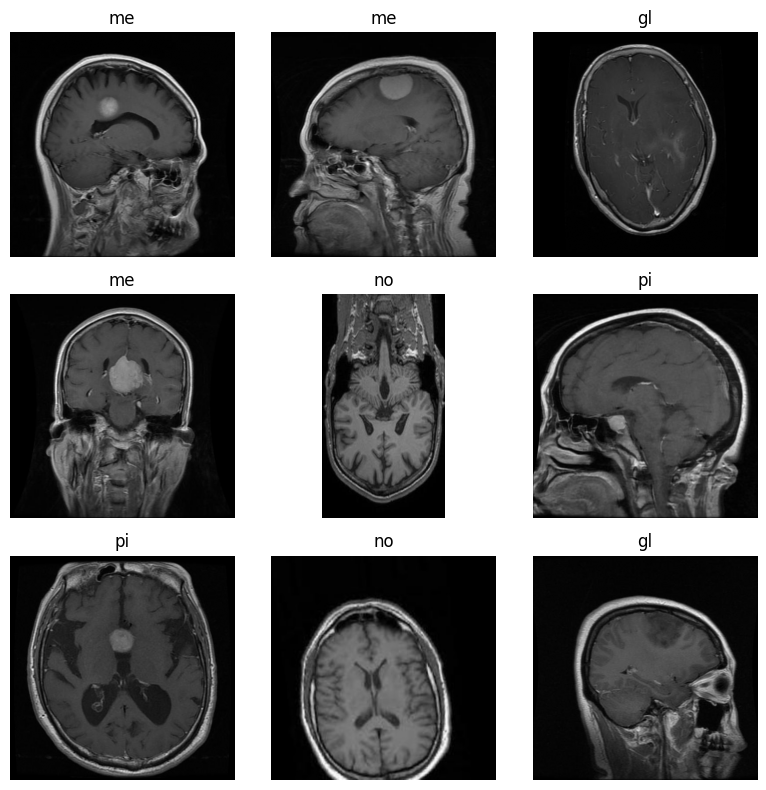

In [15]:
# In[10] — Random Grid
samples = glob.glob(os.path.join(BASE_DIR, "classification_task/train/*/*.jpg"))
grid = np.random.choice(samples, 9, replace=False)

fig, axes = plt.subplots(3,3, figsize=(8,8))
axes = axes.flatten()
for ax, fp in zip(axes, grid):
    im = Image.open(fp)
    cls = os.path.basename(fp).split("_")[3]
    ax.imshow(im, cmap="gray")
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

## 🔲 11. Dataloader para clasificacion


In [75]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

IMAGE_SIZE = 224 # para vit
IMAGE_SIZE_AUTOENCODER = 100 # para stacked autoencoder

def get_transforms(mean, std, resize_size):
    return transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

# usar este objeto con cautela. Carga TODAS las imagenes en memoria
# para hacer mas rapido el entrenamiento. No deben crearse muchas instancias o
# la session crasheara.
# opcional dejar 3 canales (para el modelo de huggingface)
class BrainTumorDataset(Dataset):
    def __init__(self, df, root_dir, resize_size):
        self.label_map = {'gl': 0, 'me': 1, 'no': 2, 'pi': 3}
        self.images = []
        self.labels = []
        self.meta = []

        for _, row in df.iterrows():
            tumor_to_file = {
                "gl":"glioma",
                "me":"meningioma",
                "no":"no_tumor",
                "pi":"pituitary"
            }
            tumor = row['Tumor']
            filename = row['Filename']

            img_path = os.path.join(root_dir, row['Split'], tumor_to_file[tumor], filename)

            image = Image.open(img_path).convert('RGB')
            self.images.append(image)
            self.labels.append(self.label_map[tumor])
            self.meta.append({"path":img_path})

        # cargamos las imagenes y calculamos el mean y std para normalizar
        mean, std = self._calculate_mean_std(resize_size)
        self.transform = get_transforms(mean, std, resize_size)

    def _calculate_mean_std(self,resize_size):
        as_tensor = transforms.Compose([
            transforms.Resize((resize_size, resize_size)),
            transforms.ToTensor()
        ])

        mean = torch.zeros(3)
        std = torch.zeros(3)

        for image in self.images:
            tensor_img = as_tensor(image)
            mean += tensor_img.mean([1, 2])
            std += tensor_img.std([1, 2])

        mean /= len(self.images)
        std /= len(self.images)

        return mean.tolist(), std.tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return {
            'pixel_values': self.transform(image).squeeze(0),  # (1, *) -> (*) Remueve la dimensión del batch
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def get_with_meta(self,idx):
        image = self.images[idx]
        return image, self.labels[idx], self.meta[idx]

def create_dataloaders(batch_size=32, resize_size = IMAGE_SIZE):
    train_df = df_meta[df_meta['Split'] == 'train']
    test_df = df_meta[df_meta['Split'] == 'test']

    train_dataset = BrainTumorDataset(train_df, BASE_DIR + 'classification_task', resize_size)
    test_dataset = BrainTumorDataset(test_df, BASE_DIR + 'classification_task', resize_size)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset

In [17]:
# tarda algo por la carga de las imagenes en memoria. Igual mejor hacerlo ahora que en entrenamiento
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders()

In [15]:
# solo correr si se quiere crear nuevas variables ya teniendo otras. por cuestiones de memoria
#del train_loader, test_loader, train_dataset, test_dataset

# ViT: El Visual Transformer

A continuación, tendrán la estructura del Visual Transformer. Su labor será utilizarlo en el task de `clasificación` de tumores del dataset `BRICS` haciendo énfasis en:

1. Cómo reajustar un codebase dado para un dataset de ejemplo?
1. Entender el modelo ViT para explicarlo a sus compañeros.
1. Cómo utilizar la matriz de atención en el caso de ViT? En qué ayuda en nuestro ejercicio?
1. Comparar nuestro ViT "casero" con el ViT de Huggingface.
1. Comparar ViT con un modelo de StackedAutoEncoders.
1. Utilizar `wandb` o `tensorboard` para el logging de los modelos.
1. Proyecto: Crear, en base al dataset dado, uno o unos gráficos custom de `wandb` siguiendo los ejemplos de [Custom charts](https://docs.wandb.ai/guides/app/features/custom-charts/)

Tienen libertad en todo el proyecto. Generen un pdf de resumen como hemos hecho en el curso y una presentación de no más de 15 diapositivas resumiendo la tarea.

In [ ]:
!pip install wandb

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
from transformers import (
    ViTImageProcessorFast,
    ViTForImageClassification,
    ViTConfig,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from transformers import ViTImageProcessorFast, ViTForImageClassification, pipeline
from datasets import load_dataset
import numpy as np
from einops import rearrange
import wandb
import time
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

WANDB_PROJECT = "vit-model-comparison"

## Seccion de respuesta

### Nuestro ViT

In [ ]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h) # Qué es esto? Investigar!!!!

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'Importante: La dimensión de las imágenes debe ser divisible por el número de patches (Dimensión/Patches = número entero)'

        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(), # Gaussian error linear unit como función de activación
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p) # Qué es esto? Investigar!!!!
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [ ]:
def train_epoch(model,optimizer, data_loader, epoch, wandb):
    total_samples = len(data_loader.dataset)
    model.train()
    epoch_loss = 0
    num_batches = 0

    for i, raw in enumerate(data_loader):
        data = raw["pixel_values"]
        target = raw["labels"]
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))

            # Log batch-level metrics to wandb
            wandb.log({
                "batch_loss": loss.item(),
                "epoch": epoch,
                "batch": i + (epoch - 1) * len(data_loader)
            })

    # Calculate and log average training loss for the epoch
    avg_train_loss = epoch_loss / num_batches
    wandb.log({
        "train_loss": avg_train_loss,
        "epoch": epoch
    })

    return avg_train_loss


In [ ]:

def evaluate(model, data_loader, epoch, wandb):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for raw in data_loader:
            data = raw["pixel_values"]
            target = raw["labels"]

            data = data.cuda()
            target = target.cuda()
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    accuracy = 100.0 * correct_samples / total_samples

    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(accuracy) + '%)\n')

    wandb.log({
        "val_loss": avg_loss,
        "val_accuracy": accuracy,
        "epoch": epoch
    })

    return avg_loss, accuracy


In [ ]:
def plot_roc_curve(model, dataloader, num_classes, wandb):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["pixel_values"].cuda()
            labels = batch["labels"].cuda()

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    labels_bin = label_binarize(all_labels, classes=range(num_classes))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)

        data = [[fp, tp] for fp, tp in zip(fpr, tpr)]
        table = wandb.Table(data=data, columns=["fpr", "tpr"])

        wandb.log({
            f"roc_curve_class_{i}": wandb.plot.line(
                table, "fpr", "tpr",
                title=f"ROC Curve Class {i} (AUC = {roc_auc:.3f})"
            )
        })

In [ ]:
def fit_model(epochs, model, wandb, model_name):
    wandb.init(
        project=WANDB_PROJECT,
        name=f"{model_name}-experiment",
        config= {
            "model_type": "vit-base",
            "patch_size": model.patch_size,
            "batch_size": train_loader.batch_size
        },
        reinit=True
    )
    wandb.watch(model, log="all", log_freq=100)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    start_time = time.time()

    best_val_accuracy = 0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        current_lr = scheduler.get_last_lr()[0]
        print('Época:', epoch, 'LR:', current_lr)
        wandb.log({"learning_rate": current_lr, "epoch": epoch})

        train_loss = train_epoch(model, optimizer, train_loader, epoch, wandb)
        val_loss, val_accuracy = evaluate(model, test_loader, epoch, wandb)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()

            torch.save(best_model_state, "best_model.pth")
            wandb.save("best_model.pth")

        scheduler.step()

    training_time = time.time() - start_time

    wandb.summary["training_time"] = training_time
    wandb.summary["best_accuracy"] = best_val_accuracy

    plot_roc_curve(model, test_loader, 4, wandb)

    wandb.finish()

In [ ]:
model = ViT(image_size=IMAGE_SIZE, patch_size=IMAGE_SIZE // 2, num_classes=4, channels=3,
            dim=64, depth=6, heads=8, mlp_dim=128)
model = model.cuda()

fit_model(20, model, wandb, "custom-vit")

### Huggingface ViT

https://huggingface.co/google/vit-base-patch16-224

---



In [ ]:
pipeline = pipeline(
    task="image-classification",
    model="google/vit-base-patch16-224",
    torch_dtype=torch.float16,
    device=0
)
pipeline("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

In [ ]:
processor = ViTImageProcessorFast.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224") # Por qué el nombre es patch16-224?

In [ ]:
def setup_model(
    n_classes=10,
    freeze_parameters=True,
    pretrained_model="google/vit-base-patch16-224",
    debug=True
):
    """
    En esta sección:
    1) Llamamos al modelo ViT pre-entrenado
    2) Modificamos la cabecera
    3) Dedicimos si modificar TODOS los pesos o solamente la capa lineal
    """
    if debug:
        print("*** Setup modelo con processor ***")
        
    # Modificamos la configuración del clasificador
    config = ViTConfig.from_pretrained(pretrained_model)
    config.num_labels = n_classes
    config.id2label = {i: str(i) for i in range(n_classes)}
    config.label2id = {str(i): i for i in range(n_classes)}

    model = ViTForImageClassification.from_pretrained(
        pretrained_model,
        config=config ,
        ignore_mismatched_sizes=True
    )

    if debug:
        print(f"Modelo cargado con {config.num_labels} clases")
        print(f"Dimensión de la capa de clasificación (luego del cambio) {model.classifier.weight.shape}")

    # To Freeze or not to Freeze
    if freeze_parameters:
        for param in model.vit.parameters():
            param.requires_grad = False

    return model, config


In [ ]:
def compute_metrics(eval_pred):
    """Compute accuracy metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

def fine_tune_con_trainer(model, train_dataset, test_dataset, output_dir="./UCV-vit-mnist-finetuned", debug=True):
    """Fine-tune using HuggingFace Trainer"""

    config ={
        "model_name": "google/vit-base-patch16-224",
        "num_epochs": 10,
        "train_batch_size": 32,
        "eval_batch_size": 64,
        "warmup_steps": 500,
        "weight_decay": 0.01
    }

    wandb.init(
        project=WANDB_PROJECT,  # Change this to your project name
        name=f"huggingface-experiment",  # Run name
        config=config
    )

    # Training arguments
    # Verificar https://huggingface.co/docs/transformers/en/main_classes/trainer
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config["num_epochs"],
        per_device_train_batch_size=config["train_batch_size"],
        per_device_eval_batch_size=config["eval_batch_size"],
        warmup_steps=config["warmup_steps"],
        weight_decay=config["weight_decay"],
        logging_dir=f'{output_dir}/logs',
        logging_steps=100,
        eval_strategy="steps",
        eval_steps=250,
        save_strategy="steps",
        save_steps=250,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to="wandb",
    )

    # Initialiar el entrenador
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    if debug:
        print("Comenzando fine-tuning...")

    # Entrenar el modelo
    trainer.train()

    # Evaluar el model
    if debug:
        print("Evaluating on test set...")
    eval_results = trainer.evaluate()

    wandb.log({
        "final_test_accuracy": eval_results['eval_accuracy'],
        "final_test_loss": eval_results['eval_loss']
    })

    if debug:
        print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

    # Salvar el modelo
    trainer.save_model()
    if debug:
        print(f"Model saved to {output_dir}")

    return trainer, eval_results

In [ ]:
import wandb
import torch
import numpy as np 
from datasets import load_dataset

def test_inference(model, dataloader):
    """Test inference with wandb logging"""

    device = next(model.parameters()).device
    model.eval()

    # Lists to store data for wandb
    sample_images = []
    predictions_data = []
    
    for data in dataloader:
        image = data['pixel_values'].to(device)
        true_label = data['labels'].to(device)
        with torch.no_grad():
            outputs = model(pixel_values=image)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities.max().item()

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {predicted_class}\nConf: {confidence:.3f}')
        axes[i].axis('off')
        
        predictions_data.append({
            "true_label": true_label,
            "predicted_label": predicted_class,
            "confidence": confidence,
            "correct": int(true_label == predicted_class)
        }) 
    
    # Log to wandb
    wandb.log({
        "inference_samples": sample_images,
        "inference_plot": wandb.Image(fig),
    })
    
    table = wandb.Table(
        columns=["true_label", "predicted_label", "confidence", "correct"],
        data=[[
            d["true_label"], 
            d["predicted_label"], 
            d["confidence"], 
            d["correct"]
        ] for d in predictions_data]
    )
    wandb.log({"inference_results": table})
    
    # Log summary stats
    accuracy = sum(d["correct"] for d in predictions_data) / len(predictions_data)
    avg_confidence = sum(d["confidence"] for d in predictions_data) / len(predictions_data)
     
    wandb.log({
        "inference_accuracy": accuracy,
        "avg_inference_confidence": avg_confidence,
        "num_inference_samples": num_samples
    })
     
    plt.show()
    return predictions_data

In [ ]:
model, config = setup_model(n_classes=4, freeze_parameters=False)
trainer, eval_results = fine_tune_con_trainer(model, train_dataset, test_dataset)

### Stacked autoencoders

In [178]:
# tarda algo por la carga de las imagenes en memoria. Igual mejor hacerlo ahora que en entrenamiento
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(resize_size = IMAGE_SIZE)

In [209]:
class AutoEncoderLayer(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=None, SelfTraining=False):
        super(AutoEncoderLayer, self).__init__()

        self.in_features = input_dim
        self.out_features = hidden_dim

        # Hacer pre-entrenamiento capa por capa si es true, o entrenar toda la red.
        self.is_training_self = SelfTraining

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.out_features, bias=True),
            nn.BatchNorm1d(self.out_features),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.out_features, self.in_features, bias=True),
            nn.BatchNorm1d(self.in_features),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.encoder(x)

        if self.is_training_self:
            return self.decoder(out)
        else:
            return out

    def lock_grad(self):
        for param in self.parameters():
            param.requires_grad = False

    def acquire_grad(self):
        for param in self.parameters():
            param.requires_grad = True

    @property
    def input_dim(self):
        return self.in_features

    @property
    def output_dim(self):
        return self.out_features

    @property
    def is_training_layer(self):
        return self.is_training_self

    @is_training_layer.setter
    def is_training_layer(self, other: bool):
        self.is_training_self = other

class StackedAutoEncoderClassifier(nn.Module):
    def __init__(self, autoencoder_list=None, num_classes=10):
        super(StackedAutoEncoderClassifier, self).__init__()

        # Utilizamos solamente la capa de codificación de cada AutoEncoder
        self.encoder_layers = nn.ModuleList([autoencoder.encoder for autoencoder in autoencoder_list])
        self.num_classes = num_classes

        # La capa de clasificación toma la última salida del encoder y mapea a número de clases
        self.classification_layer = nn.Linear(autoencoder_list[-1].out_features, num_classes)

    def forward(self, x):
        encoded_representation = x
        for layer in self.encoder_layers:
            encoded_representation = layer(encoded_representation)

        # Classification layer
        output = self.classification_layer(encoded_representation)
        return output


In [210]:
def train_layer(layers_list=None, layer=None, epochs=20): 
    if torch.cuda.is_available():
        for model in layers_list:
            model.cuda()

    optimizer = optim.SGD(layers_list[layer].parameters(), lr=0.1)
    criterion = torch.nn.MSELoss()

    # Entrenamiento
    for epoch_index in range(epochs):
        sum_loss = 0.

        if layer != 0:
            for index in range(layer):
                # Congelamos los pesos de la capa
                layers_list[index].lock_grad()
                # Asignamos la salida de la capa congelada
                layers_list[index].is_training_layer = False

        for batch_index, raw in enumerate(train_loader):
            image = raw["pixel_values"].cuda()
            out = image.view(image.size(0), -1)

            if layer != 0:
                for l in range(layer):
                    out = layers_list[l](out)
                    
            pred = layers_list[layer](out)
            optimizer.zero_grad()
            loss = criterion(pred, out)
            
            sum_loss += loss
            loss.backward()
            optimizer.step()
            
        print("Capa de entrenamiento: {}, Época: {}/{}, Iter: {}/{}, L(theta): {:.4f}".format(
            layer, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))


In [211]:
import torch.optim as optim

def train_classifier(model=None, epochs=20, batch_size = 32):
    if torch.cuda.is_available():
        model.cuda()
 
    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.SGD(model.parameters(), lr=1)
    criterion = nn.CrossEntropyLoss()

    # Modelo en modalidad entrenamiento
    model.train()
    # Entrenamiento
    for epoch_index in range(epochs):
        sum_loss = 0.
        for batch_index, raw in enumerate(train_loader):
            image = raw["pixel_values"].cuda()
            label = raw = raw["labels"].cuda()
             
            out = image.view(image.size(0), -1)

            predicted_labels = model(out)

            optimizer.zero_grad()
            loss = criterion(predicted_labels, label)
            sum_loss += loss
            loss.backward()
            optimizer.step()

        print("Entrenamiento fine tuning, Época: {}/{}, Iter: {}/{}, L(theta): {:.4f}"
              .format(
                  (epoch_index + 1), 
                  epochs, 
                  (batch_index + 1), 
                  len(train_loader), 
                  loss
              )
        )

    # Colocar modelo en fase de evaluación
    model.eval()

    # Calcular accuracy en el test set
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for raw in test_loader:
            images = raw["pixel_values"].cuda()
            labels = raw = raw["labels"].cuda()
            
            images = images.view(images.size(0), -1)
            if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # Obtenemos el valor máximo
            _, predicted_labels = torch.max(outputs.data, 1)
            # Contamos predicciones correctas
            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)


    # Calculamos el accuracy del test set
    accuracy = total_correct / total_samples
    print('Accuracy en el test set: {:.6f}'.format(accuracy))
    return model, accuracy


In [217]:
num_layer_wise_epochs = 10
num_classifier_epochs = 10
num_finetuning_epochs = 20
batch_size = 32
input_dim = IMAGE_SIZE*IMAGE_SIZE * 3 # la imagen y los 3 canales

layer_dims = [input_dim, 1024, 512, 256,128]
layer_dims

[150528, 1024, 512, 256, 128]

In [218]:
encoder_list = [
    AutoEncoderLayer(input_dim = layer_dims[i-1], hidden_dim = layer_dims[i], SelfTraining=True)
    for i in range(1,len(layer_dims))
]

for model in encoder_list:
    total_params = sum(param.numel() for param in model.parameters())
    print(f"Total number of parameters: {total_params}")

encoder_list

Total number of parameters: 308736000
Total number of parameters: 1053184
Total number of parameters: 264448
Total number of parameters: 66688


[AutoEncoderLayer(
   (encoder): Sequential(
     (0): Linear(in_features=150528, out_features=1024, bias=True)
     (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=1024, out_features=150528, bias=True)
     (1): BatchNorm1d(150528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
 ),
 AutoEncoderLayer(
   (encoder): Sequential(
     (0): Linear(in_features=1024, out_features=512, bias=True)
     (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=512, out_features=1024, bias=True)
     (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
 ),
 AutoEncoderLayer(
   (encoder): Sequential(
     (0): Linear(in_features=512, out_features=256, bias=True)
     (1): BatchNorm1d(2

In [219]:
for level in range(len(encoder_list)):
   train_layer(layers_list=encoder_list, layer=level, epochs=num_layer_wise_epochs)

Capa de entrenamiento: 0, Época: 1/10, Iter: 157/157, L(theta): 1.3818
Capa de entrenamiento: 0, Época: 2/10, Iter: 157/157, L(theta): 1.4196
Capa de entrenamiento: 0, Época: 3/10, Iter: 157/157, L(theta): 1.3831
Capa de entrenamiento: 0, Época: 4/10, Iter: 157/157, L(theta): 1.6552
Capa de entrenamiento: 0, Época: 5/10, Iter: 157/157, L(theta): 1.4125
Capa de entrenamiento: 0, Época: 6/10, Iter: 157/157, L(theta): 1.4900
Capa de entrenamiento: 0, Época: 7/10, Iter: 157/157, L(theta): 1.3477
Capa de entrenamiento: 0, Época: 8/10, Iter: 157/157, L(theta): 2.0796
Capa de entrenamiento: 0, Época: 9/10, Iter: 157/157, L(theta): 1.3587
Capa de entrenamiento: 0, Época: 10/10, Iter: 157/157, L(theta): 1.4673
Capa de entrenamiento: 1, Época: 1/10, Iter: 157/157, L(theta): 0.1359
Capa de entrenamiento: 1, Época: 2/10, Iter: 157/157, L(theta): 0.1506
Capa de entrenamiento: 1, Época: 3/10, Iter: 157/157, L(theta): 0.0532
Capa de entrenamiento: 1, Época: 4/10, Iter: 157/157, L(theta): 0.0757
Capa 

In [220]:
# Modelo de StackedAutoEncoder
SAE_model = StackedAutoEncoderClassifier(autoencoder_list=encoder_list, num_classes = 4)
# Print the model
print(SAE_model)

StackedAutoEncoderClassifier(
  (encoder_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=150528, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (classification_layer): Linear(in_features=128, out_features=4, bias=True)
)


In [221]:
# Train the whole model and perform fine-tuning
train_classifier(model=SAE_model, epochs=num_finetuning_epochs, batch_size = batch_size)

CNNNNN
Entrenamiento fine tuning, Época: 1/20, Iter: 157/157, L(theta): 1.1973
Entrenamiento fine tuning, Época: 2/20, Iter: 157/157, L(theta): 1.2774
Entrenamiento fine tuning, Época: 3/20, Iter: 157/157, L(theta): 0.3586
Entrenamiento fine tuning, Época: 4/20, Iter: 157/157, L(theta): 0.5761
Entrenamiento fine tuning, Época: 5/20, Iter: 157/157, L(theta): 0.6207
Entrenamiento fine tuning, Época: 6/20, Iter: 157/157, L(theta): 0.0281
Entrenamiento fine tuning, Época: 7/20, Iter: 157/157, L(theta): 0.0882
Entrenamiento fine tuning, Época: 8/20, Iter: 157/157, L(theta): 1.2760
Entrenamiento fine tuning, Época: 9/20, Iter: 157/157, L(theta): 0.1036
Entrenamiento fine tuning, Época: 10/20, Iter: 157/157, L(theta): 0.7631
Entrenamiento fine tuning, Época: 11/20, Iter: 157/157, L(theta): 0.0043
Entrenamiento fine tuning, Época: 12/20, Iter: 157/157, L(theta): 0.9344
Entrenamiento fine tuning, Época: 13/20, Iter: 157/157, L(theta): 0.8340
Entrenamiento fine tuning, Época: 14/20, Iter: 157/15

(StackedAutoEncoderClassifier(
   (encoder_layers): ModuleList(
     (0): Sequential(
       (0): Linear(in_features=150528, out_features=1024, bias=True)
       (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): Linear(in_features=1024, out_features=512, bias=True)
       (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): Linear(in_features=512, out_features=256, bias=True)
       (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): Linear(in_features=256, out_features=128, bias=True)
       (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
   )
   (classification_layer): Linear(in_features=128, out_features=4, bias=True)
 ),
 0.813)

In [ ]:
def setup_modelo_con_processor(
    n_classes=10, # Default 10 porque es MNIST
    freeze_parameters=True,
    pretrained_model="google/vit-base-patch16-224",
    debug=True
):
    """
    En esta sección:
    1) Llamamos al modelo ViT pre-entrenado
    2) Modificamos la cabecera
    3) Dedicimos si modificar TODOS los pesos o solamente la capa lineal
    """
    if debug:
        print("*** Setup modelo con processor ***")
    # Cargamos el processor
    processor = ViTImageProcessorFast.from_pretrained(pretrained_model)

    # Modificamos la configuración del clasificador
    config = ViTConfig.from_pretrained(pretrained_model)
    config.num_labels = n_classes
    config.id2label = {i: str(i) for i in range(n_classes)}
    config.label2id = {str(i): i for i in range(n_classes)}

    model = ViTForImageClassification.from_pretrained(
        pretrained_model,
        config=config ,
        ignore_mismatched_sizes=True
    )

    if debug:
        print(f"Modelo cargado con {config.num_labels} clases")
        print(f"Dimensión de la capa de clasificación (luego del cambio) {model.classifier.weight.shape}")

    # To Freeze or not to Freeze
    if freeze_parameters:
        for param in model.vit.parameters():
            param.requires_grad = False

    return model, processor, config


In [ ]:
def cargar_y_preparar_datos(processor, debug=True):
    """Cargar datos usando el processor"""
    if debug:
        print("*** Cargar y preparar datos ***")
    # Ejemplo con MNIST
    # Acá se puede modificar para tumores
    mnist = load_dataset("mnist")

    # Crear datasets
    train_dataset = MNISTDataset(mnist['train'], processor)
    test_dataset = MNISTDataset(mnist['test'], processor)
    if debug:
        print(f"Datos de entrenamiento: {len(train_dataset)}")
        print(f"Datos de test: {len(test_dataset)}")

    return train_dataset, test_dataset

In [ ]:
def compute_metrics(eval_pred):
    """Compute accuracy metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

def fine_tune_con_trainer(model, train_dataset, test_dataset, output_dir="./UCV-vit-mnist-finetuned", debug=True):
    """Fine-tune using HuggingFace Trainer"""

    # Training arguments
    # Verificar https://huggingface.co/docs/transformers/en/main_classes/trainer
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'{output_dir}/logs',
        logging_steps=100,
        eval_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to=None,  # Disable wandb/tensorboard !!!!!PROYECTO!!!!!
    )

    # Initialiar el entrenador
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    if debug:
        print("Comenzando fine-tuning...")

    # Entrenar el modelo
    trainer.train()

    # Evaluar el model
    if debug:
        print("Evaluating on test set...")
    eval_results = trainer.evaluate()

    if debug:
        print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

    # Salvar el modelo
    trainer.save_model()
    if debug:
        print(f"Model saved to {output_dir}")

    return trainer, eval_results

In [ ]:
def test_inference(model, processor, num_samples=5):
    """Test inference en un split aleatorio de los datos"""

    # Load test dataset
    mnist = load_dataset("mnist")

    device = next(model.parameters()).device
    model.eval()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        # Get random sample
        idx = np.random.randint(0, len(mnist['test']))
        sample = mnist['test'][idx]
        image = sample['image']
        true_label = sample['label']

        # Preprocess
        rgb_image = image.convert('RGB')
        inputs = processor(images=rgb_image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)

        # Predict
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities.max().item()

        # Plot
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {predicted_class}\nConf: {confidence:.3f}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### Salvando y carga en el caso de modelos salvados

In [ ]:
def save_model_for_deployment(model, processor, save_path="./vit-mnist-final", load=False, debug=True):
    """
    Salvar y upload de modelos
    """
    if load:
            # Test loading
        try:
            loaded_model = ViTForImageClassification.from_pretrained(save_path)
            loaded_processor = ViTImageProcessorFast.from_pretrained(save_path)
            if debug:
                print("✓ Modelo y processor cargados correctamente!")
            return loaded_model, loaded_processor
        except Exception as e:
            print(f"✗ Error loading model: {e}")
            return None, None
    else:
        os.makedirs(save_path, exist_ok=True)

        # Save model
        model.save_pretrained(save_path)

        # Save processor
        processor.save_pretrained(save_path)

        if debug:
            print(f"Modelo y processor salvados en {save_path}")



In [ ]:
print("ViT fine tuning")

model, processor, config = setup_modelo_con_processor()
train_dataset, test_dataset = cargar_y_preparar_datos(processor)
trainer, eval_results = fine_tune_con_trainer(model, train_dataset, test_dataset)

In [ ]:
test_inference(model, processor, num_samples=5)

Colocamos la bandera `load=False` si solo queremos salvar

In [ ]:
save_model_for_deployment(model, processor, save_path="./vit-mnist-final", load=False)

In [ ]:
model_saved, processor_saved = save_model_for_deployment(model=None, processor=None, save_path="./vit-mnist-final", load=True)

In [ ]:
test_inference(model_saved, processor_saved, num_samples=5)